# Algoritmo de Wang-Landau
Arthur Souto Lima - 2018055113

## Imports e Funções Auxiliares

### Imports

Imports de funções das bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

Importar as funções do script python que implementa o algoritmo de Wang-Landau, utilizando Numba, como recomendado. Há também funções auxiliares advindas da atividade anterior. Ao final do relatório, o script é apresentado na íntegra.

In [2]:
from wang import energy_ising, energy_scale, neighbours, random_energy_state

### Algoritmos de Propriedades Termodinâmicas

Os algoritmos utilizados na atividade anterior foram aqui adaptados para utilizar o logaritmo da densidade de estados.

In [3]:
def media_termo(lg, N, beta):
    """
    Obtém as propriedades termodinâmicas a uma dada temperatura (com inverso beta),
    dada o logaritmo de energias por configuração (lnG).
    Adaptação do algoritmo da atividade anterior
    """
    Z = 0
    Em = 0
    Em2 = 0
    
    Emin = energy_unscale(0,N)
    Emax = energy_unscale(N,N)
    
    for E_scaled in range(N):
        E = energy_unscale(E_scaled,N)   # Acha a energia sem escala
        
        E1 = E - Emin
        gE = np.exp(lg[E_scaled])    # Desfaz o logaritmo
        Z = Z + gE*np.exp(-beta*E1)
        Em = Em + E1*gE*np.exp(-beta*E1)
        Em2 = Em2 + E1*E1*gE*np.exp(-beta*E1)
    Em = Em/Z
    Em2 = Em2/Z
    
    # longdouble porque a multiplicação causa overflow às vezes
    Z = Z*np.exp((np.longdouble(-beta*Emin)))  # Potencial overflow
    cv = (beta*beta*(Em2-Em**2))/N
    EpS = (Em + Emin)/N
    return Z, EpS, cv

In [4]:
def energia_livre_spin(Z, N, beta):
    """
    Calcula a energia livre por spin, usando a fórmula do enunciado.
    Note que a função np.log é o logaritmo natural.
    Idêntico ao da atividade anterior
    """
    result = N * beta
    result = -1/result
    result = result * np.log(Z)  # np.log é o logaritmo natural
    return result

In [5]:
def entropia_spin(e_spin, e_livre_spin, temp):
    """
    Calcula a entropia livre por spin, usando a fórmula do enunciado.
    Note que utiliza a temperatura e não o inverso dela (beta).
    Idêntico ao da atividade anterior
    """
    result = e_spin - e_livre_spin
    result = result / temp
    return result

### Algoritmo Magnetização

Utilizando a fórmula fornecida no enunciado, pode-se montar uma função para o cálculo da magnetização média a partir da média microcanônica obtida durante o método de Wang-Landau. Seguindo orientações também do enunciado, usa-se aqui um truque para evitar overflow em exponenciais. Além disso, numa multiplicação específica foi necessário usar o _long double_ pois o tamanho do _double_ não foi suficiente

In [6]:
from math import isnan

def magn(lg, mmicro, Z, N, beta):
    """
    Obtém a magnetização média a partir da média microcanônica
    """
    # Truque para evitar overflow nas exponenciais
    truque = 0
    for E_scaled in range(N):
        E = energy_unscale(E_scaled, N)
        if ((-beta*E) > truque):
            truque = E

    soma = 0
    for E_scaled in range(N):
        # Pula as energias não permitidas
        if (isnan(mmicro[E_scaled])): continue
        
        # Desfaz o logaritmo
        gE = np.exp(lg[E_scaled])
        E = energy_unscale(E_scaled, N)
        
        # Forma o termo da soma
        termo = mmicro[E_scaled]
        # longdouble porque a multiplicação causa overflow às vezes
        termo *= np.exp((np.longdouble(-beta*E))-truque)   
        termo *= gE
        soma += termo
    return soma/Z

## Simulações

Utilizando o script, mas invocando-o via shell do notebook, vamos simular para obter as redes 6x6, 12x12, 18x18 e 24x24. Estamos fazendo dessa forma pois houve problemas com o kernel do Jupyter Notebook em redes maiores que 12x12. As redes são computadas e guardadas em arquivos com nomes específicos.

Sem entrar muito em detalhes no que é cada número das saídas intermediárias, o último número de cada linha sempre é o $lnf$ corrente. Assim, como esperado, ele acaba diminuindo com o passar das linhas

In [7]:
%time !python wang.py 6

2057.14 1679.0 1679.0 1645.71 10000 0.001953125
Criado rede 6x6
CPU times: user 45 ms, sys: 23 ms, total: 68 ms
Wall time: 3 s


In [8]:
%time !python wang.py 12

15104.9 12272.0 12272.0 12083.92 490000 7.450580596923828e-09
Criado rede 12x12
CPU times: user 92.7 ms, sys: 18.4 ms, total: 111 ms
Wall time: 5.6 s


In [9]:
%time !python wang.py 18

74229.1 59723.0 59723.0 59383.28 280000 1.52587890625e-05
72222.91 57786.0 57786.0 57778.33 810000 9.5367431640625e-07
Criado rede 18x18
CPU times: user 354 ms, sys: 76.4 ms, total: 431 ms
Wall time: 21.6 s


In [10]:
%time !python wang.py 24

5008.7 4230.0 4230.0 4006.96 40000 0.03125
Criado rede 24x24
CPU times: user 1.12 s, sys: 709 ms, total: 1.83 s
Wall time: 1min 36s


## Resultados e Discussão

### Carregamento do Arquivo

As redes foram salvas em arquivos do tipo _wangLxL.dict_ e _magLxL.dict_, com o $L$ correspondente. Vamos carregá-las para fazer algumas discussões

In [11]:
L = 6
lg6 = None
mmicro6 = None
with open(f"wang{L}x{L}.dict", "rb") as f:
    lg6 = pickle.load(f)
with open(f"mag{L}x{L}.dict", "rb") as f:
    mmicro6 = pickle.load(f)

In [12]:
L = 12
lg12 = None
mmicro12 = None
with open(f"wang{L}x{L}.dict", "rb") as f:
    lg12 = pickle.load(f)
with open(f"mag{L}x{L}.dict", "rb") as f:
    mmicro12 = pickle.load(f)

In [13]:
L = 18
lg18 = None
mmicro18 = None
with open(f"wang{L}x{L}.dict", "rb") as f:
    lg18 = pickle.load(f)
with open(f"mag{L}x{L}.dict", "rb") as f:
    mmicro18 = pickle.load(f)

In [14]:
L = 24
lg24 = None
mmicro24 = None
with open(f"wang{L}x{L}.dict", "rb") as f:
    lg24 = pickle.load(f)
with open(f"mag{L}x{L}.dict", "rb") as f:
    mmicro24 = pickle.load(f)

### Comparação com Enumeração Exata

Na atividade anterior, não foi possível executar a rede 6x6, pois demorava bastante. Naquele contexto, inseriu-se manualmente a solução exata. Nesse momento, com orientações do professor sobre algumas bibliotecas, como o Numba, não se teve mais problemas com tempos de execução no algoritmo de Wang-Landau. 

Vamos carregar, portanto, do mesmo arquivo da atividade passada, a rede 6x6 exata e comparar com a do arquivo da rede 6x6 aproximada desse momento para vermos o desempenho desse algoritmo frente à solução exata.

In [15]:
L = 6
N = L**2
g6 = None
with open(f"rede{L}x{L}.dict", "rb") as f:
    g6 = pickle.load(f)

# Escalando-os usando a equação 
g6_scaled = np.zeros(N+1, dtype=np.float64)
for key,val in g6.items():
    i = energy_scale(N,key)
    g6_scaled[i] = val

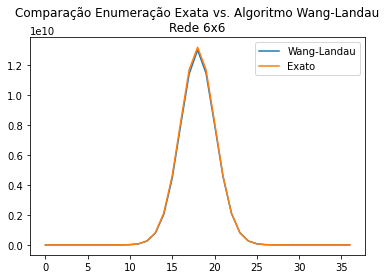

In [16]:
plt.plot(np.exp(lg6))
plt.plot(g6_scaled)
plt.legend(["Wang-Landau","Exato"])
plt.title("Comparação Enumeração Exata vs. Algoritmo Wang-Landau\nRede 6x6");

Como vimos na aula, o algoritmo de Wang-Landau, tendo como base o método de Monte Carlo, com quantidade suficiente de iterações, se aproxima bastante da enumeração exata. Esse resultado nos ratifica isso com as duas curvas bastante próximas. Possivelmente, com mais iterações ou com uma condição de saída (limite inferior do $lnf$), teríamos resultados ainda mais próximos.

### Distribuições de Energia

Tal como foi feito na atividade anterior, vamos plotar o histograma das distribuições de energia comparando as redes de tamanhos diferentes. Contudo, já que fizemos uma escala das energias para facilitar a indexação, vamos ter que desfazê-la para poder tê-la novamente entre $-2$ e $+2$.

In [17]:
def energy_unscale(E, N):
    """
    Desfaz a escala dos valores de energia para que fiquem entre -2N até 2N
    ao invés de entre 0 e N 
    """
    E = 4*E - 2*N
    if (int(E) - E > 0):
        print("Energia não inteira pós re-escala!")
    return int(E)

Agora podemos coletar os dados do histograma, o eixo x será de $\frac{E}{N}$, como requisitado pelo enunciado, permitindo a comparação. Convém lembrar que, tendo em vista que as energias $-2N+4$ e $2N-4$ não são permitidas, ignoramos esses dois valores 0 na coleta e análise a seguir

In [18]:
x_6 = []
y_6 = []
N = 6**2
for i in range(len(lg6)):
    if (lg6[i] == 0): continue
    E = energy_unscale(i, N)
    x_6.append(E/N)
    y_6.append(lg6[i])

In [19]:
x_12 = []
y_12 = []
N = 12**2
for i in range(len(lg12)):
    if (lg12[i] == 0): continue
    E = energy_unscale(i, N)
    x_12.append(E/N)
    y_12.append(lg12[i])

In [20]:
x_18 = []
y_18 = []
N = 18**2
for i in range(len(lg18)):
    if (lg18[i] == 0): continue
    E = energy_unscale(i, N)
    x_18.append(E/N)
    y_18.append(lg18[i])

In [21]:
x_24 = []
y_24 = []
N = 24**2
for i in range(len(lg24)):
    if (lg24[i] == 0): continue
    E = energy_unscale(i, N)
    x_24.append(E/N)
    y_24.append(lg24[i])

Finalmente pode-se ver o histograma. Tomou-se um outro logaritmo na escala do eixo y para facilitar a visualização além do logaritmo tomado da distribuição de energia.

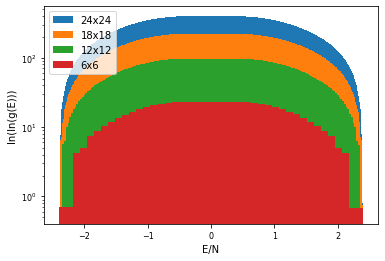

In [22]:
# Tomamos o log de log(g(E)) para melhor visualizar
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
ax = plt.gca()
ax.bar(x_24,y_24)
ax.bar(x_18,y_18)
ax.bar(x_12,y_12)
ax.bar(x_6,y_6)
plt.ylabel("ln(ln(g(E)))")
plt.yscale("log")
plt.xlabel("E/N")
plt.legend(["24x24","18x18","12x12","6x6"]);

Os resultados aqui continuam a tendência observada na atividade anterior. Há uma imensa concentração de estados nas energias baixas em torno de 0. Além disso, redes maiores possuem mais configurações que as menores em praticamente todos os possíveis estados de energia. Apesar da escala logarítmica, vê-se uma simetria com relação ao $x=0$.

### Propriedades Termodinâmicas

Utilizando a adaptação dos algoritmo da atividade anterior para usar o logaritmo da quantidade de configurações por energia, apresentada em seção anterior, vamos coletar os dados e discutir algumas observações.

In [23]:
# Alocação de vetores para os dados
x_6 , y1_6 , y2_6 , y3_6 , y4_6 , m_6  = [], [], [], [], [], []
x_12, y1_12, y2_12, y3_12, y4_12, m_12 = [], [], [], [], [], []
x_18, y1_18, y2_18, y3_18, y4_18, m_18 = [], [], [], [], [], []
x_24, y1_24, y2_24, y3_24, y4_24, m_24 = [], [], [], [], [], []

In [24]:
# Parâmetros do Loop
step = 0.01
t_min = 1
t_max = 5

In [25]:
def prop_termodinamicas_mag(N, lg, mmicro, beta, temp, 
                            x, y1, y2, y3, y4, mag):
    """
    Calcula as propriedades termodinâmicas dada a distribuição de estados
    e média microcanônica para a rede de tamanho fornecido.
    
    Adiciona as 5 propriedades nos vetores respectivos, nessa ordem:
    Energia por spin, calor específico, energia livre por spin,
    entropia por spin e magnetização média.
    
    Adiciona também a temperatura no vetor x fornecido
    """
    Z, EpS, cv = media_termo(lg, N, beta)
    x.append(temp)
    y1.append(EpS)  # Energia por spin
    y2.append(cv)   # Calor específico
    liv_spin = energia_livre_spin(Z, N, beta)
    y3.append(liv_spin)   # Energia livre por spin
    y4.append(entropia_spin(EpS, liv_spin, temp))  # Entropia por spin
    mag.append(magn(lg, mmicro, Z, N, beta))  # Magnetização Média

In [26]:
for temp in np.arange(t_min,t_max,step):
    beta = 1/temp
    
    # 6x6
    prop_termodinamicas_mag(6**2, lg6, mmicro6, beta, temp, 
                            x_6, y1_6, y2_6, y3_6, y4_6, m_6)
    # 12x12
    prop_termodinamicas_mag(12**2, lg12, mmicro12, beta, temp, 
                            x_12, y1_12, y2_12, y3_12, y4_12, m_12)
    
    # 18x18
    prop_termodinamicas_mag(18**2, lg18, mmicro18, beta, temp, 
                            x_18, y1_18, y2_18, y3_18, y4_18, m_18)
    
    # 24x24
    prop_termodinamicas_mag(24**2, lg24, mmicro24, beta, temp, 
                            x_24, y1_24, y2_24, y3_24, y4_24, m_24)

#### Calor Específico

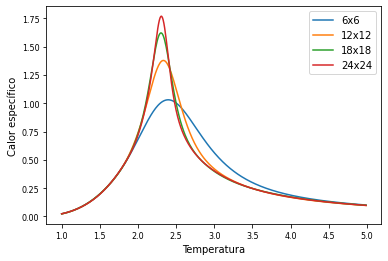

In [27]:
# Plot Calor Específico
plt.plot(x_6 ,y2_6 )
plt.plot(x_12,y2_12)
plt.plot(x_18,y2_18)
plt.plot(x_24,y2_24)
plt.ylabel("Calor específico")
plt.xlabel("Temperatura")
plt.legend(["6x6","12x12","18x18","24x24"])
plt.show()

As conclusões observacionais das curvas de calor específico são as mesmas que fizemos na atividade anterior. Há um notável pico dessa grandeza em torno de 2.5 de temperatura, podendo indicar, como apontado em outros momentos, uma transição de fase nesse ponto. Aqui é mantida a ordenação observada na enumeração exata, isto é, no pico do gráfico, redes maiores tem picos mais altos, mas, apesar disso, tem uma queda mais vertiginosa que as menores.

#### Energia por Spin e Energia Livre por Spin

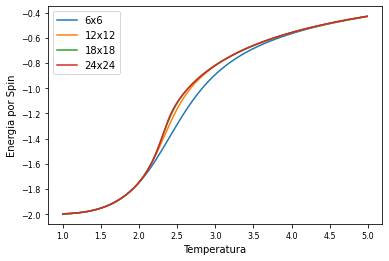

In [28]:
# Plot Energia por Spin
plt.plot(x_6 ,y1_6 )
plt.plot(x_12,y1_12)
plt.plot(x_18,y1_18)
plt.plot(x_24,y1_24)
plt.ylabel("Energia por Spin")
plt.xlabel("Temperatura")
plt.legend(["6x6","12x12","18x18","24x24"])
plt.show()

Novamente, as conclusões são parecidas: a energia por sítio aumenta com o aumento da temperatura. Além disso, embora não tão claro de se perceber, nota-se que em redes maiores, o aumento é mais rápido, principalmente a partir da temperatura de 2.

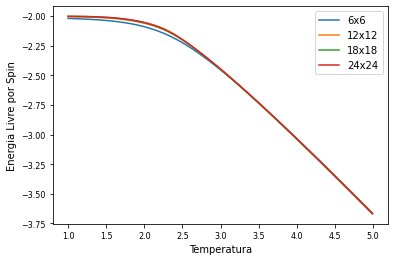

In [29]:
# Plot Energia Livre por Spin
plt.plot(x_6 ,y3_6 )
plt.plot(x_12,y3_12)
plt.plot(x_18,y3_18)
plt.plot(x_24,y3_24)
plt.ylabel("Energia Livre por Spin")
plt.xlabel("Temperatura")
plt.legend(["6x6","12x12","18x18","24x24"])
plt.show()

Vê-se que a energia livre diminui com o aumento da temperatura. O queda torna-se mais forte a partir de 2 ou 2.5, aproximadamente onde a energia por spin aumentou de forma mais rápida. Nesse caso, com redes bem maiores, todas posuem curvas muito semelhantes, o que não aconteceu, por exemplo, com a rede 2x2 na atividade passada nessa mesma grandeza, que era destacadamente diferente das outras curvas plotadas.

#### Entropia por Spin

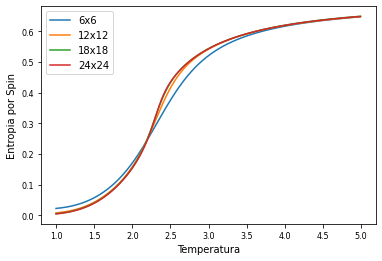

In [30]:
# Plot Entropia por Spin
plt.plot(x_6 ,y4_6 )
plt.plot(x_12,y4_12)
plt.plot(x_18,y4_18)
plt.plot(x_24,y4_24)
plt.ylabel("Entropia por Spin")
plt.xlabel("Temperatura")
plt.legend(["6x6","12x12","18x18","24x24"])
plt.show()

Em concordância com o que vimos na atividade anterior, com o aumento da temperatura, há um aumento da entropia do sistema. É notável que à temperatura de 1, a entropia do 6x6 é maior do que a das outras redes. Além disso, a rede 24x24 tem a menor nesse ponto. Apesar da diferença, todas estão próximas de 0 aqui na temperatura de 1. De forma parecida com o resultado exato, em torno de 2.5, a ordem das curvas se inverte com o aumento da entropia do sistema. Contudo, essa inversão não se torna tão relevante com o fato de que a partir da temperatura de 3.5 as curvas estão praticamente sobrepostas.   

#### Magnetização Média

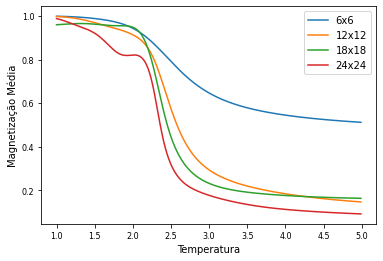

In [31]:
# Plot Entropia por Spin
plt.plot(x_6 ,m_6 )
plt.plot(x_12,m_12)
plt.plot(x_18,m_18)
plt.plot(x_24,m_24)
plt.ylabel("Magnetização Média")
plt.xlabel("Temperatura")
plt.legend(["6x6","12x12","18x18","24x24"])
plt.show()

Após normalização dos dados, vemos que todas as redes tem uma magnetização maior entre 0 e 2.5. Após esse ponto de temperatura tão relevante, a magnetização de todas as redes tem uma queda. Em linhas gerais, quanto maior a rede, menor a magnetização final e mais vertical é a queda. Assim, a rede 6x6 é a que tem a menor queda e o mais alto nível final, enquanto a 24x24 é a que tem a maior queda e mais baixo nível final de magnetização média.

## Script _wang.py_

Abaixo o script _wang.py_, apenas para fins de relatório. Ele, ou algumas de suas funções, são invocadas ao longo do relatório

In [ ]:
# %load wang.py
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import argparse
import pickle

@jit(nopython=True)
def neighbours(N, L):
    """
    Constrói a matriz de vizinhança.
    Assume que há uma "vizinhança circular" como se a rede 
    fosse um toro.
    Adaptação do algoritmo proposto no enunciado
    """
    # Idêntico ao da atividade anterior

In [ ]:
@jit(nopython=True)
def energy_ising(s, viz):
    """
    Calcula a energia da rede Ising usando os vizinhos de cada sítio.
    É importante notar que precisamos apenas dos 
    vizinhos à direita e acima
    """
    E = 0
    N = len(s)
    for i in range(N):
        right = viz[i][0]
        up = viz[i][1]
        h = s[right] + s[up]
        E = E - s[i]*h
    return E

@jit(nopython=True)
def sub_min(H):
    """
    Retorna o mínimo do vetor H, ignorando o segundo e penúltimo itens
    """
    n = len(H)
    menor = H[0]
    for i in range(n):
        if (i == 1 or i == n-2):
            continue
        if (H[i] < menor):
            menor = H[i]
    return menor

In [ ]:
@jit(nopython=True)
def energy_scale(N,E):
    """
    Escala os valores de energia para que fiquem entre 0 e N 
    ao invés de -2N até 2N
    """
    E = E+2*N
    E = E/4
    if (int(E) - E > 0):
        print("Energia não inteira pós escala!")
    return int(E)

@jit(nopython=True)
def random_energy_state(N):
    """
    Gera um estado aleatório de energia
    """
    s = []
    # De 0 a N-1
    for i in range(N):
        s.append(np.sign(2*np.random.random()-1))
    s = np.array(s)
    return s

In [ ]:
@jit(nopython=True)
def wang_landau(N, E, s):
    """
    Algoritmo de Wang-Landau para estimativa da densidade de estados g(E)
    """
    # Inicialização arrays, de 0 a N, inclusive
    lnG = np.zeros(N+1, dtype=np.float64)
    H = np.zeros(N+1, dtype=np.int64)
    Hc = np.zeros(N+1, dtype=np.int64)
    mmicro = np.zeros(N+1, dtype=np.float64)
    viz = neighbours(N, np.sqrt(N))
    
    # Variáveis do Loop Principal
    lnf = 1.0
    flat = False
    m = s.sum()
    for i in range(10**7):
        for j in range(N):
            # Escolhe um sítio aleatório
#             rng = np.random.default_rng()
            k = np.random.randint(N)
            
            # Soma sobre os vizinhos de k
            h = 0
            for v_idx in viz[k]:
                h += s[v_idx]
            
            # Energia desse novo estado
            E2 = E + s[k]*h/2
            if (int(E2) - E2 > 0): print("Energia não inteira pós iteração!")
            E2 = int(E2)

            # Economizar algumas exponenciais
            if lnG[E] > lnG[E2]:
                # Faz a troca
                s[k] = -s[k]
                E = E2
                m = m - 2*s[k]
            else:
#                 rng = np.random.default_rng()
                P = np.exp(lnG[E] - lnG[E2])
                if (np.random.random() < P):
                    # Faz a troca
                    s[k] = -s[k]
                    E = E2
                    m = m - 2*s[k]
            H[E] = H[E] + 1
            lnG[E] = lnG[E] + lnf
            mmicro[E] = mmicro[E] + np.abs(m)
            
        if (i % 1000 == 0):
            hmed = np.sum(H)/(N-1)
            hmin = sub_min(H)

            if (hmin > 0.8*hmed):
                Hc = H.copy()
                H = np.zeros(N+1, dtype=np.int64)
                lnf = lnf/2
                if (i % 10000 == 0):
                    print(round(hmed,2),round(hmin,2),round(hmin,2),
                        round(0.8*hmed,2), i, lnf)
        if (lnf < 10**-8):
            break
    mmicro = mmicro/Hc
    # Normalizar o vetor de magnetização
    maior = max(mmicro)
    mmicro = mmicro / maior
    lnG0 = lnG[0]
    lnG = lnG - lnG0 + np.log(2)
    return lnG, mmicro

In [ ]:
def main():
    # Parse dos argumentos
    parser = argparse.ArgumentParser()
    parser.add_argument("L", help="Tamanho da rede LxL")
    args = parser.parse_args()
    L = int(args.L)

    N = L**2
    s = random_energy_state(N)
    viz = neighbours(N,np.sqrt(N))
    E = energy_ising(s,viz)
    E = energy_scale(N,E)
    lnG, mmicro = wang_landau(N, E, s)
    with open("wang"+str(L)+"x"+str(L)+".dict", "wb") as f:
        pickle.dump(lnG, f)
    with open(f"mag"+str(L)+"x"+str(L)+".dict", "wb") as f:
        pickle.dump(mmicro, f)
    print("Criado rede "+str(L)+"x"+str(L))

if __name__=="__main__":
    main()